In [324]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np
#additional imports for the models
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as mt
from sklearn.model_selection import cross_val_score
from sklearn import metrics
pd.set_option('display.max_columns', 500)
%matplotlib inline

In [325]:
!ls

#IBMHacksTeams.xlsx     models.ipynb            preds2.csv
IBM_hackathon.ipynb     predictions.csv         testing.csv
IBM_hackathon_old.ipynb preds.csv               training.csv
Problem_Statement.docx  preds11.csv


In [326]:
pdata = pd.read_csv('./training.csv', na_values=['?','nan'])
pdata.drop(["county", "community" , "communityname"],axis=1, inplace=True)

tdata = pd.read_csv('./testing.csv', na_values=['?','nan'])
#tdata.drop(["county", "community" , "communityname"],axis=1, inplace=True)

In [327]:
X = pdata[pdata.columns[pdata.isnull().mean() < 0.8]]

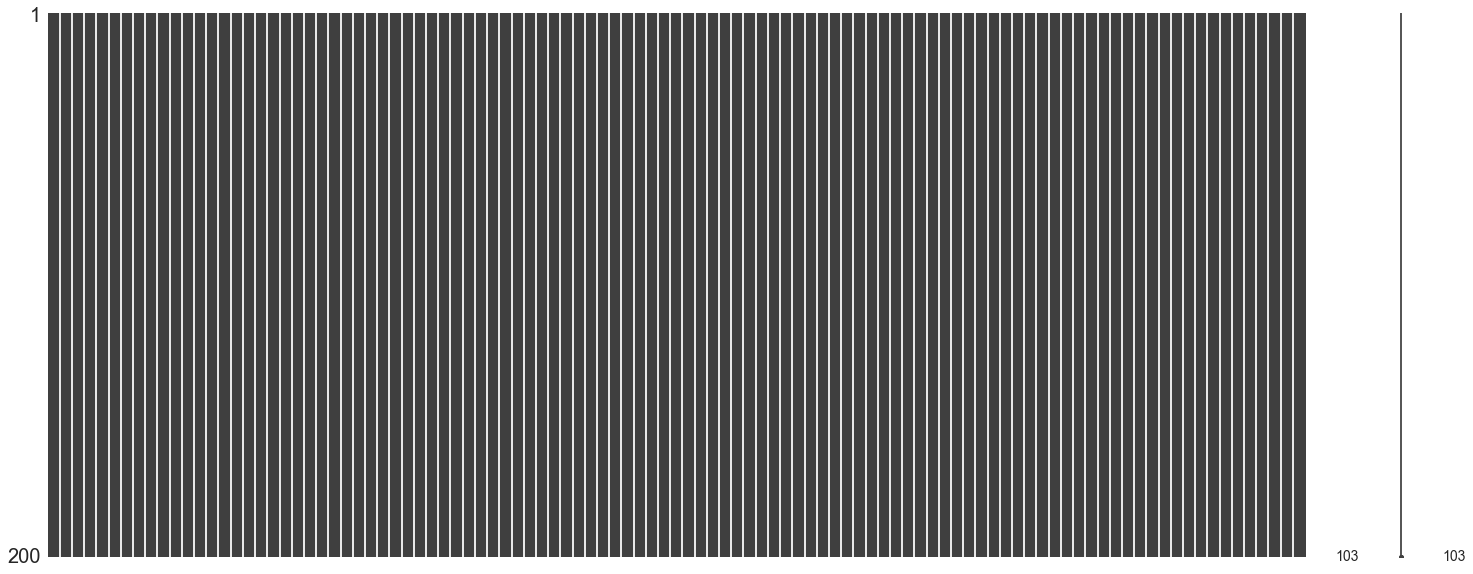

In [328]:
import missingno as msno
%matplotlib inline
msno.matrix(X.sample(200))# med_income #pctwage

In [329]:
def get_dtype(s):  #get data type with regex (is float?)
    import re    
    if re.match("^\d+?\.\d+?$", s) is None:
        if s.isdigit():
            return "int"
        else:
            return "string"
    return "float"


def process_dtypes(df): #read data, and assign data types accordingly  
    try:
        del catFeatures 
        del numFeatures 
        catFeatures = []
        numFeatures = []
    except:
        catFeatures = []
        numFeatures = []
    for col,x in df.iloc[1,:].iteritems():
        t = get_dtype(str(x).strip())
        if(t == "int" or t == "float" ):
            numFeatures.append(col)
            #if t == "int":
            #    df[col] = df[col].astype(int)
            #else:
            #   df[col] = df[col].astype(float)
        else:
            catFeatures.append(col)
            #df[col] = df[col].astype(str)
    return catFeatures,    numFeatures 

In [330]:
catFeatures, numFeatures = process_dtypes(X)

In [331]:
import itertools
from scipy import stats

outliers_lst  = []
log_data = X.copy()

# For each feature find the data points with extreme high or low values
for feature in log_data.columns:
    
    pdwn = np.percentile(log_data.loc[:, feature], 3) #values in bottom 1 percentile
    pup = np.percentile(log_data.loc[:, feature], 97) #values in upper 1 percentile
    #Using the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    
    step = 1.5 * (pup - pdwn)
    
    # The tilde sign ~ means not
    # So here, we're finding any points outside of Q1 - step and Q3 + step
    outliers_rows = log_data.loc[~((log_data[feature] >= pdwn - step) & (log_data[feature] <= pup + step)), :]
    
    print("Outliers for the feature '{}':".format(feature), len(outliers_rows[feature]))
    outliers_lst.append(list(outliers_rows.index))
outliers = list(itertools.chain.from_iterable(outliers_lst))
uniq_outliers = list(set(outliers))

# List of duplicate outliers
dup_outliers = list(set([x for x in outliers if outliers.count(x) > 1]))
print( 'Total Number of outliers:\n', len(uniq_outliers))

# Remove duplicate outliers
# Only 5 specified
X1 = log_data.drop(log_data.index[dup_outliers]).reset_index(drop = True)
X1 += 1 
X1 = np.log(abs(X1))
# Original Data 
print( 'Original shape of data:\n', X.shape)
# Processed Data
print( 'New shape of data:\n', X1.shape)

Outliers for the feature 'state': 0
Outliers for the feature 'fold': 0
Outliers for the feature 'population': 14
Outliers for the feature 'householdsize': 0
Outliers for the feature 'racepctblack': 0
Outliers for the feature 'racePctWhite': 0
Outliers for the feature 'racePctAsian': 0
Outliers for the feature 'racePctHisp': 0
Outliers for the feature 'agePct12t21': 0
Outliers for the feature 'agePct12t29': 0
Outliers for the feature 'agePct16t24': 0
Outliers for the feature 'agePct65up': 0
Outliers for the feature 'numbUrban': 12
Outliers for the feature 'pctUrban': 0
Outliers for the feature 'medIncome': 0
Outliers for the feature 'pctWWage': 0
Outliers for the feature 'pctWFarmSelf': 0
Outliers for the feature 'pctWInvInc': 0
Outliers for the feature 'pctWSocSec': 0
Outliers for the feature 'pctWPubAsst': 0
Outliers for the feature 'pctWRetire': 0
Outliers for the feature 'medFamInc': 0
Outliers for the feature 'perCapInc': 0
Outliers for the feature 'whitePerCap': 0
Outliers for the

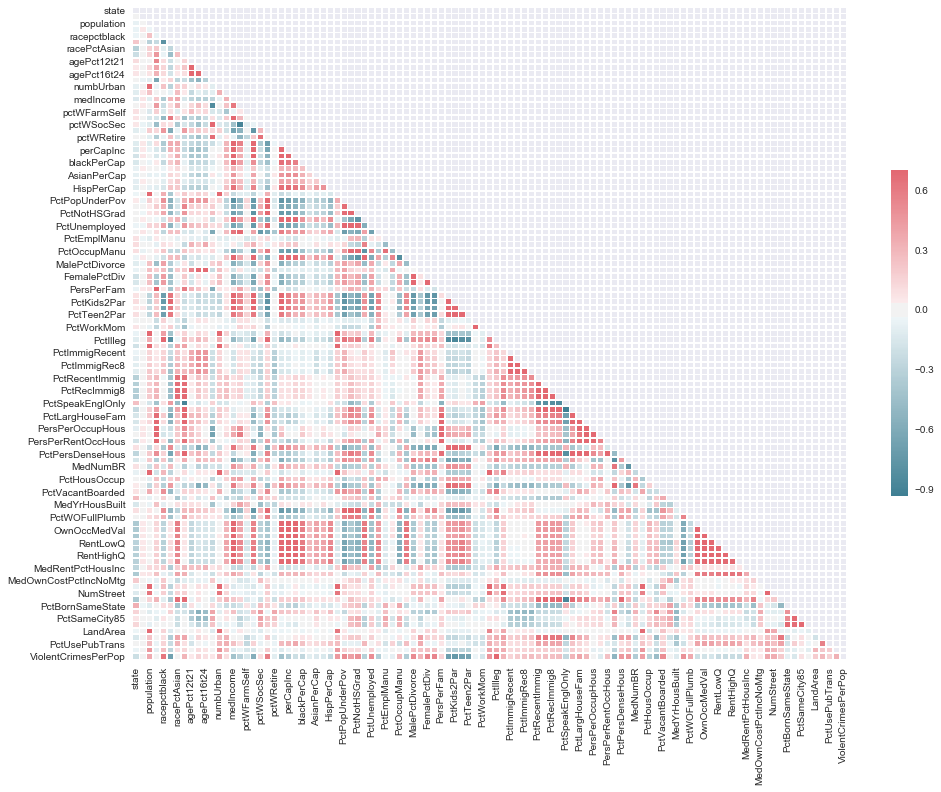

In [332]:
%matplotlib inline
sns.set(rc={'figure.figsize':(16,12)})
corr = X.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.7, center=0, linewidths=.8, cbar_kws={"shrink": .5})

In [333]:
data_cor = X.corr()
# Set the threshold and add to pairs to list
t = 0.98
cor_list = []

#Find Pairs and update cor_list
for i in range(0,102):
    for j in range(i+1,102):
        if (data_cor.iloc[i,j] >= t and data_cor.iloc[i,j] < 1) or (data_cor.iloc[i,j] < 0 and data_cor.iloc[i,j] <= -t):
            cor_list.append([data_cor.iloc[i,j],i,j])

#Sort by corr coef
sorted_list = sorted(cor_list,key=lambda x: -abs(x[0]))

for v,i,j in sorted_list:
    print ("%s and %s = %.5f" % (numFeatures[1:][i],numFeatures[1:][j],v))
    #print ("%s and %s = %.5f" % (numFeatures[1:][i],numFeatures[1:][j],v))

PctRecImmig10 and PctSpeakEnglOnly = 0.99552
OwnOccMedVal and OwnOccHiQuart = 0.99466
PctRecImmig8 and PctRecImmig10 = 0.99415
householdsize and pctUrban = 0.99353
OwnOccHiQuart and RentLowQ = 0.99155
PctRecImmig5 and PctRecImmig8 = 0.98935
RentHighQ and MedRentPctHousInc = 0.98902
PctRecImmig8 and PctSpeakEnglOnly = 0.98674
PctKids2Par and PctYoungKids2Par = 0.98489
PctLargHouseOccup and PersPerOccupHous = 0.98414
TotalPctDiv and PersPerFam = 0.98274
PctPersDenseHous and PctVacantBoarded = 0.98200
RentHighQ and MedRent = 0.98194
PctRecImmig5 and PctRecImmig10 = 0.98015


In [334]:
#X.describe().T

In [335]:
y = X1["ViolentCrimesPerPop"]
X = X1.drop(["ViolentCrimesPerPop"], axis=1)
numFeatures.remove("ViolentCrimesPerPop")
# process_dtypes(X1)

In [336]:
#numFeatures.remove("OtherPerCap")
X_train, X_test, y_train, y_test = train_test_split(X[numFeatures], y, test_size=0.20, random_state=2111)

In [337]:
tdata = pd.read_csv('./testing.csv', na_values=['?','nan'])
tdata.drop(["county", "community" , "communityname"],axis=1, inplace=True)
tdata = tdata[X_train.columns].fillna(tdata[X_train.columns].median())

In [338]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error


model = linear_model.RidgeCV(alphas=[0.1, 1.0, 3.0, 4.0])
model.fit(X_train, y_train)

Y_pred=model.predict(X_test)
print("MSE", mean_squared_error(y_test,Y_pred)) #MAE difference between observation 
print("R2_score", r2_score(y_test,Y_pred, multioutput='variance_weighted')) #R2 models explained variance

MSE 0.0112878979901
R2_score 0.617943132761


In [339]:
model.fit(X, y)
pd.DataFrame(model.predict(tdata[numFeatures])).to_csv("./preds2.csv")

In [340]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, y)

print('resulting features:')
print(result)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


Add  PctKids2Par                    with p-value 6.45268e-274
Add  PctPersDenseHous               with p-value 1.46543e-33
Add  HousVacant                     with p-value 2.95755e-21
Add  racepctblack                   with p-value 1.11147e-16
Add  state                          with p-value 7.63185e-08
Add  pctUrban                       with p-value 3.33106e-06
Add  PctWorkMom                     with p-value 0.000129304
Add  MalePctDivorce                 with p-value 1.37766e-05
Add  PctIlleg                       with p-value 0.0002324
Add  NumStreet                      with p-value 0.0017896
Add  numbUrban                      with p-value 0.00286863
Add  PctSameCity85                  with p-value 0.00394267
resulting features:
['PctKids2Par', 'PctPersDenseHous', 'HousVacant', 'racepctblack', 'state', 'pctUrban', 'PctWorkMom', 'MalePctDivorce', 'PctIlleg', 'NumStreet', 'numbUrban', 'PctSameCity85']


## Best Model : after stepwise selection, log transformation and, outlier cleaning 

In [358]:
from sklearn import linear_model
model = linear_model.RidgeCV(alphas=[0.1, 1.0, 3.0, 4.0])
best_features = result

model.fit(X_train[result], y_train)
Y_pred=model.predict(X_test[result])
print("MSE", mean_squared_error(y_test,Y_pred)) #MAE difference between observation 
print("R2_score", r2_score(y_test,Y_pred, multioutput='variance_weighted')) #R2 models explained variance

MSE 0.0107845499775
R2_score 0.634979747106


#### Our suggestions to DOJ could be based on following factors

'PctKids2Par', 'PctPersDenseHous', 'HousVacant', 'racepctblack', 'state', 'pctUrban', 'PctWorkMom', 'MalePctDivorce', 'PctIlleg', 'NumStreet', 'numbUrban', 'PctSameCity85'

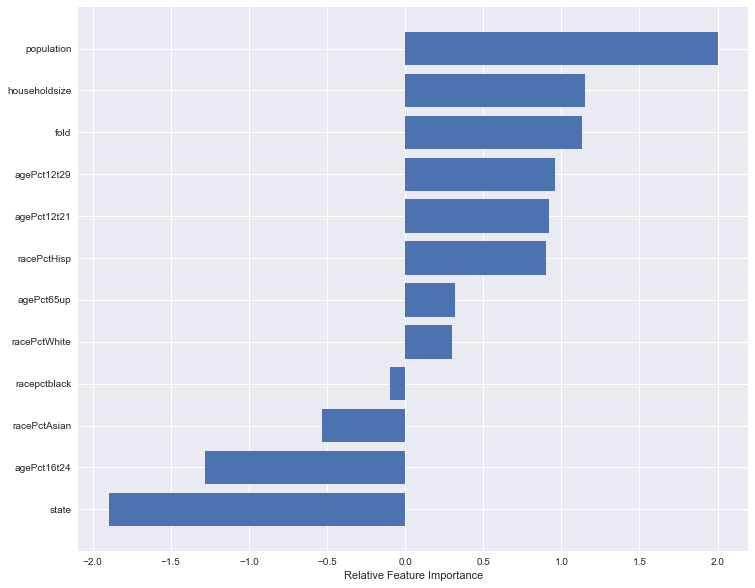

In [363]:

feature_importance = (model.coef_)

feature_importance = 2 * (feature_importance/max(feature_importance))
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .7
#print(list(zip(np.array(X.columns)[sorted_idx], feature_importance[sorted_idx] )))

featfig = plt.figure(figsize=(12, 10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)
featax.set_xlabel('Relative Feature Importance')

plt.show()

### Positive(Factors to right that increase crime-rate) vs Negative Correlation(Factors to left that lower crime rates) to the C

In [342]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

est = GradientBoostingRegressor(n_estimators=500, learning_rate=0.009,
    max_depth=7, random_state=0, loss='ls').fit(X_train, y_train)
print("MSE", mean_squared_error(y_test, est.predict(X_test)))
print("R2_score",r2_score(y_test,est.predict(X_test), multioutput='variance_weighted'))

MSE 0.0110216890609
R2_score 0.626953397523


In [343]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=10,
           max_features=8, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=380, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=10,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=380, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [344]:
print("MSE", mean_squared_error(y_test, rf.predict(X_test)))
print("R2_score",r2_score(y_test,rf.predict(X_test), multioutput='variance_weighted'))

MSE 0.0109115270371
R2_score 0.630682006494


In [345]:
from sklearn.kernel_ridge import KernelRidge

model = KernelRidge(kernel='rbf', gamma=0.2)
best_features = result

model.fit(X_train[result], y_train)
Y_pred=model.predict(X_test[result])
print("MSE", mean_squared_error(y_test,Y_pred)) #MAE difference between observation 
print("R2_score", r2_score(y_test,Y_pred, multioutput='variance_weighted')) #R2 models explained variance

MSE 0.0109893967639
R2_score 0.628046381696


In [346]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

cv = 3

paramGrid = {
    # Parameters that we are going to tune.
    'max_depth':[4,5,6],
    'subsample': [1],
    'colsample_bytree': [1],
    # Other parameters
    'objective':['reg:linear'],
    "n_estimators" : [100,200,300]
}

fit_params={"early_stopping_rounds":42, 
            "eval_metric" : "mae", 
            "eval_set" : [[X_test, y_test]]}

model = xgb.XGBRegressor()
gridsearch = GridSearchCV(model, paramGrid, verbose=1 ,
         fit_params=fit_params,
         cv=TimeSeriesSplit(n_splits=cv).get_n_splits([X_train,y_train]))
#gridsearch.fit(X_train,y_train)

In [347]:
#params = gridsearch.best_params_
xgbn = xgb.XGBRegressor(n_estimators=200)
model = xgbn.fit(X_train, y_train)

In [348]:
print("MSE", mean_squared_error(y_test, model.predict(X_test)))
print("R2_score",r2_score(y_test,model.predict(X_test), multioutput='variance_weighted'))

MSE 0.0108834017896
R2_score 0.631633950243


In [349]:
feats = list(X.columns)

In [351]:
preds = pd.DataFrame(model.predict(tdata[feats]))
preds.to_csv("./predictions.csv")

### Deep Learning Models: take way too long to train

In [301]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(200, input_dim=102, kernel_initializer='normal', activation='relu'))
    model.add(Dense(102, kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    #model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    #model.add(Dense(20, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)

In [354]:
kfold = KFold(n_splits=3, random_state=seed)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Results: %.3f (%.3f) MSE" % (results.mean(), results.std()))

Results: -0.012 (0.003) MSE


In [355]:
results

array([-0.01556151, -0.01117579, -0.00917187])

In [364]:
estimator.fit(X_train, y_train)
Y_pred=estimator.predict(X_test)
print("MAE", mean_squared_error(y_test,Y_pred)) #MAE difference between observation 
print("R2_score", r2_score(y_test,Y_pred)) #R2 models explained variance

MAE 0.0111633554517
R2_score 0.622158473126


In [ ]:
def wider_model():
	# create model
	model = Sequential()
	model.add(Dense(200, input_dim=102, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model

In [ ]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=wider_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Wider: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
pipeline.fit(X,y)

In [ ]:
preds_cnn = pipeline.predict(tdata[numFeatures])

In [ ]:
pd.DataFrame(preds_cnn).to_csv("./preds11.csv")